# Kibble-Zureck Mechanism Analysis

### Imports

In [1]:
#Imports
import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
from tqdm import tqdm_notebook

import pint

import support as sp

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

### Tracking Files List 

In [2]:
directory = r"C:\Users\Eric\Documents\Python_Scripts\Kibbke-Zurek\20191001" #20190912 20191003

In [3]:
pre_list = sp.get_names(directory,ext = ".dat")

pre_list = pre_list[:]

omit = []

pre_list = [name for name in pre_list if 
     all([os.path.split(name)[-1]!=item for item in omit])]

video_list = pre_list

# date = "20190722"
# video_list = []

# for video in pre_list:
#     if date in video:
#         video_list.append(video)

In [4]:
len(video_list)

900

# Methods

In [5]:
def load_process(name):#, final_radius = 32.329):
    
    trj = sp.load_data(name) #sp.load_dat(name) #
    trj = sp.from_px_to_um(trj, 0.1805)
    trj = sp.check_N_particles(trj)
    trj = sp.recenter(trj)
    trj = sp.get_polar_coordinates(trj)
    
    last_frame = trj.index.get_level_values("frame").unique().to_list()[-62]#sp.find_final_frame(trj, final_radius)
    trj = trj.loc[idx[last_frame,:],:]
    trj = sp.sort_particles_in_circle(trj)
    
    trj = sp.set_particle_positions(trj)
    
    trj = sp.configure_domains(trj)
    trj = sp.obtain_domain_walls(trj)
    
    return trj

In [6]:
def data_selector(test, video_list):
    
    tracking_files = []

    for video in video_list:
        
        if test in video:
        
            tracking_files.append(video)
            
    return tracking_files

# Single File Process

In [8]:
tracking_files = []

for video in video_list:
    if "Test02_" in video:
        tracking_files.append(video)
        
len(tracking_files)

60

In [9]:
tracking_test = tracking_files[0]
tracking_test

'C:\\Users\\Eric\\Documents\\Python_Scripts\\Kibbke-Zurek\\20191001\\Tracking_Test02_0'

In [10]:
trj = load_process(tracking_test)
trj.head()

x          y          r     theta  position  domain  \
frame particle                                                                
1187  0        -32.168528  -3.316209  32.339007 -3.038867       1.0     0.0   
      1        -29.695279  -6.610978  30.422271 -2.922538      -1.0     0.0   
      2        -29.730630 -10.744574  31.612596 -2.794800       1.0     0.0   
      3        -27.211423 -14.000617  30.601941 -2.666403      -1.0     0.0   
      4        -25.943835 -17.925315  31.534101 -2.536981       1.0     0.0   

                domain_walls  
frame particle                
1187  0                  2.0  
      1                 -2.0  
      2                  2.0  
      3                 -2.0  
      4                  2.0

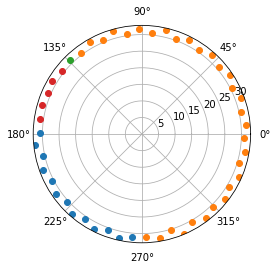

In [11]:
for l, trj_sub in trj.groupby("domain"):
    plt.polar(trj_sub.theta, trj_sub.r,'o')

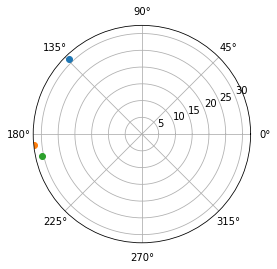

In [12]:
plt.polar(trj[trj.index.get_level_values("particle")==43].theta, trj[trj.index.get_level_values("particle")==43].r,'o')
plt.polar(trj[trj.index.get_level_values("particle")==0].theta, trj[trj.index.get_level_values("particle")==0].r,'o')
plt.polar(trj[trj.index.get_level_values("particle")==1].theta, trj[trj.index.get_level_values("particle")==1].r,'o')
# plt.polar(trj[trj.index.get_level_values("particle")==2].theta, trj[trj.index.get_level_values("particle")==2].r,'o')

In [13]:
domains = []
for d in trj.domain.unique():
    domains.append(len(trj[trj.loc[idx[:,:], "domain"]==d]))

domain_length = np.mean(domains)
print(domain_length)

12.5


In [14]:
(trj.domain_walls == 0).sum()

4

In [15]:
def find_domain_head(trj):
    
    particle_list = trj[trj.domain == 0].index.get_level_values("particle").unique().to_list()
    head_particle = 0
    
    if len(particle_list) > 1:
        for i in np.linspace(0,len(particle_list)-1,len(particle_list),dtype=int):

            if particle_list[i+1] - particle_list[i] != 1:
                head_particle = particle_list[i]
                break

    return head_particle

In [15]:
trj.domain.unique()

array([0., 1., 2., 3.])

In [16]:
domain_head = 0
domain_defect_df = pd.DataFrame()

for domain in trj.domain.unique():
    
    dom_def = np. NaN
    
    if domain == 0.:
        domain_head = find_domain_head(trj)
    else:
        domain_head = trj[trj.domain == domain].index.min()[1]
        
    if trj.loc[idx[:,domain_head], "position"].values == 1:
        dom_def = 0
    else:
        dom_def = 1
    
    #Encontrar si es defecto o no y coger la longitud del defecto y del dominio
    domain_defect_df = domain_defect_df.append({"domain/defect": dom_def,"length": len(trj[trj.domain == domain])}, ignore_index=True) #domain/defect: 0 = domain, 1 = defect

In [17]:
domain_defect_df

,domain/defect,length
0,1.0,15.0
1,1.0,17.0
2,1.0,6.0
3,0.0,12.0


In [18]:
lp = trj.index.get_level_values("particle").unique().to_list()[-1]
lp

49

In [19]:
trj.position.values[0]

1.0

In [20]:
trj[trj.domain == 1]

x          y          r     theta  position  domain  \
frame particle                                                                
1850  14         9.139832 -29.304606  30.696848 -1.268467      -1.0     1.0   
      15        13.121167 -30.426868  33.135470 -1.163655       1.0     1.0   
      16        14.958563 -26.725529  30.626990 -1.060528      -1.0     1.0   
      17        18.820076 -25.165225  31.424255 -0.928666       1.0     1.0   
      18        21.777885 -22.283993  31.158508 -0.796884      -1.0     1.0   
      19        24.704825 -19.367719  31.391669 -0.664887       1.0     1.0   
      20        26.568403 -15.698106  30.859529 -0.533669      -1.0     1.0   
      21        29.458229 -12.713980  32.084771 -0.407442       1.0     1.0   
      22        28.749577  -8.666520  30.027433 -0.292785      -1.0     1.0   
      23        31.312660  -5.413659  31.777199 -0.171198       1.0     1.0   
      24        30.765631  -1.303400  30.793228 -0.042340      -1.0     1.0   
      25        31.343205   2.777932  31.466067  0.088398       1.0     1.0   
      26        29.765507   6.609310  30.490464  0.218501      -1.0     1.0   
      27        30.332319  10.675188  32.156013  0.338403       1.0     1.0   
      28        27.414067  13.548960  30.579493  0.459024      -1.0     1.0   
      29        26.184225  17.464649  31.474237  0.588227       1.0     1.0   
      30        23.360435  20.456017  31.050902  0.719209      -1.0     1.0   

                domain_walls  
frame particle                
1850  14                 0.0  
      15                 2.0  
      16                -2.0  
      17                 2.0  
      18                -2.0  
      19                 2.0  
      20                -2.0  
      21                 2.0  
      22                -2.0  
      23                 2.0  
      24                -2.0  
      25                 2.0  
      26                -2.0  
      27                 2.0  
      28                -2.0  
      29                 2.0  
      30                -2.0

In [21]:
trj[trj.domain == 0]

x          y          r     theta  position  domain  \
frame particle                                                                
1850  0        -31.256791  -3.354238  31.436252 -3.034689       1.0     0.0   
      1        -29.428787  -7.017918  30.254003 -2.907494      -1.0     0.0   
      2        -29.982387 -11.131169  31.981971 -2.786108       1.0     0.0   
      3        -27.089714 -14.102116  30.540502 -2.661624      -1.0     0.0   
      4        -26.181767 -18.091131  31.824110 -2.536945       1.0     0.0   
      5        -22.812297 -20.401919  30.604562 -2.411914      -1.0     0.0   
      6        -20.981396 -24.089932  31.945951 -2.287334       1.0     0.0   
      7        -17.106055 -25.451744  30.666079 -2.162549      -1.0     0.0   
      8        -14.493855 -28.619748  32.080552 -2.039573       1.0     0.0   
      9        -10.383988 -28.943501  30.749853 -1.915260      -1.0     0.0   
      10        -6.939312 -31.193718  31.956253 -1.789691       1.0     0.0   
      11        -2.853417 -30.821182  30.952985 -1.663113      -1.0     0.0   
      12         1.171924 -31.532274  31.554044 -1.533648       1.0     0.0   
      13         5.238419 -30.745998  31.189060 -1.402040      -1.0     0.0   
      49       -30.952822   0.742042  30.961715  3.117624      -1.0     0.0   

                domain_walls  
frame particle                
1850  0                  2.0  
      1                 -2.0  
      2                  2.0  
      3                 -2.0  
      4                  2.0  
      5                 -2.0  
      6                  2.0  
      7                 -2.0  
      8                  2.0  
      9                 -2.0  
      10                 2.0  
      11                -2.0  
      12                 2.0  
      13                -2.0  
      49                 0.0

In [22]:
trj[trj.domain == 3].index.min()[1]

37

In [23]:
trj.index.min()[1]

0

# Multi File Process

In [16]:
tests = ["Test02_", "Test03_", "Test04_", "Test05_", "Test06_", "Test07_", "Test08_", "Test09_", "Test10_",
         "Test11_", "Test12_", "Test13_", "Test14_", "Test15_", "Test16_", "Test17_"] #"Test01_",
test_time = [20, 14, 10, 8, 6, 5, 4, 3, 2, 1, 0.8, 0.6, 0.5, 0.45, 0.3, 0.2, 0.1] #, 0.1]#[30, 15, 3]
omd = pd.DataFrame()

#last_radius = 32.3

i = 0
for test in tqdm_notebook(tests):
    
    tracking_files = data_selector(test, video_list)
    test_num = 0

    for tracking_test in tracking_files:
        
        trj = load_process(tracking_test)#, last_radius)
        
        domains = []

        for d in trj.domain.unique():
            domains.append(len(trj[trj.loc[idx[:,:], "domain"]==d]))

        domain_length = np.mean(domains)

        omd = omd.append({"test":int(test[-3:-1]), "test_num":test_num, "r":trj.r.mean(),
                          "n_walls":(trj.domain_walls == 0).sum(), "dom_length":domain_length,
                          "time":test_time[i]}, ignore_index=True)
        test_num+=1
    
    i+=1

In [17]:
omd = omd.set_index(["test", "test_num"])
omd

dom_length  n_walls          r  time
test test_num                                      
2.0  0.0        12.500000      4.0  31.230438  20.0
     1.0         8.333333      6.0  31.283914  20.0
     2.0        12.500000      4.0  31.272274  20.0
     3.0         6.250000      8.0  31.286443  20.0
     4.0        25.000000      2.0  31.259065  20.0
     5.0        12.500000      4.0  31.261976  20.0
     6.0        12.500000      4.0  31.282924  20.0
     7.0        25.000000      2.0  31.270675  20.0
     8.0        12.500000      4.0  31.259127  20.0
     9.0        12.500000      4.0  31.264847  20.0
     10.0       25.000000      2.0  31.265638  20.0
     11.0       12.500000      4.0  31.260779  20.0
     12.0       12.500000      4.0  31.277472  20.0
     13.0       12.500000      4.0  31.246938  20.0
     14.0       12.500000      4.0  31.245733  20.0
     15.0        6.250000      8.0  31.275299  20.0
     16.0        8.333333      6.0  31.271510  20.0
     17.0       12.500000      4.0  31.268500  20.0
     18.0        6.250000      8.0  31.282186  20.0
     19.0       12.500000      4.0  31.253371  20.0
     20.0       12.500000      4.0  31.265409  20.0
     21.0        6.250000      8.0  31.291276  20.0
     22.0       12.500000      4.0  31.246265  20.0
     23.0       12.500000      4.0  31.260491  20.0
     24.0        5.000000     10.0  31.301632  20.0
     25.0        6.250000      8.0  31.262437  20.0
     26.0       12.500000      4.0  31.263954  20.0
     27.0        8.333333      6.0  31.283379  20.0
     28.0       12.500000      4.0  31.282738  20.0
     29.0        8.333333      6.0  31.252362  20.0
...                   ...      ...        ...   ...
16.0 30.0        1.315789     38.0  32.513429   0.3
     31.0        1.190476     42.0  32.523816   0.3
     32.0        1.250000     40.0  32.575504   0.3
     33.0        1.250000     40.0  32.465276   0.3
     34.0        1.315789     38.0  32.448888   0.3
     35.0        1.388889     36.0  32.448159   0.3
     36.0        1.250000     40.0  32.446712   0.3
     37.0        1.315789     38.0  32.478872   0.3
     38.0        1.136364     44.0  32.477041   0.3
     39.0        1.250000     40.0  32.487564   0.3
     40.0        1.470588     34.0  32.496161   0.3
     41.0        1.136364     44.0  32.517742   0.3
     42.0        1.190476     42.0  32.518383   0.3
     43.0        1.190476     42.0  32.556055   0.3
     44.0        1.250000     40.0  32.563889   0.3
     45.0        1.190476     42.0  32.440550   0.3
     46.0        1.190476     42.0  32.431612   0.3
     47.0        1.250000     40.0  32.452631   0.3
     48.0        1.315789     38.0  32.447041   0.3
     49.0        1.190476     42.0  32.480344   0.3
     50.0        1.315789     38.0  32.456184   0.3
     51.0        1.388889     36.0  32.467642   0.3
     52.0        1.250000     40.0  32.512740   0.3
     53.0        1.136364     44.0  32.524274   0.3
     54.0        1.190476     42.0  32.558287   0.3
     55.0        1.250000     40.0  32.558987   0.3
     56.0        1.250000     40.0  32.456659   0.3
     57.0        1.470588     34.0  32.452310   0.3
     58.0        1.136364     44.0  32.464456   0.3
     59.0        1.250000     40.0  32.472792   0.3

[900 rows x 4 columns]

In [18]:
omd.to_csv("KZ_data_20191001",sep="\t")

# KZM Analysis

In [1]:
#Imports
import os 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import matplotlib.pyplot as plt
import scipy.spatial as spa
import scipy.optimize as spo
from tqdm import tqdm_notebook

import pint

import support as sp

%matplotlib inline

idx = pd.IndexSlice

%load_ext autoreload
%autoreload 2

In [2]:
file = "KZ_data_20191001"
kzd = pd.read_csv(file, sep = "\t", index_col = [0,1])
kzd.head()

dom_length  n_walls          r  time
test test_num                                      
2.0  0.0        12.500000      4.0  31.230438  20.0
     1.0         8.333333      6.0  31.283914  20.0
     2.0        12.500000      4.0  31.272274  20.0
     3.0         6.250000      8.0  31.286443  20.0
     4.0        25.000000      2.0  31.259065  20.0

In [3]:
kzd["defect_density"] = kzd.n_walls/50
kzd.head()

dom_length  n_walls          r  time  defect_density
test test_num                                                      
2.0  0.0        12.500000      4.0  31.230438  20.0            0.08
     1.0         8.333333      6.0  31.283914  20.0            0.12
     2.0        12.500000      4.0  31.272274  20.0            0.08
     3.0         6.250000      8.0  31.286443  20.0            0.16
     4.0        25.000000      2.0  31.259065  20.0            0.04

In [4]:
kzd["vel"] = (-kzd.r+34.675)/kzd.time #34.675 is the initial radius
kzd["inv_time"] = 1/kzd.time
kzd.head()

dom_length  n_walls          r  time  defect_density       vel  \
test test_num                                                                   
2.0  0.0        12.500000      4.0  31.230438  20.0            0.08  0.172228   
     1.0         8.333333      6.0  31.283914  20.0            0.12  0.169554   
     2.0        12.500000      4.0  31.272274  20.0            0.08  0.170136   
     3.0         6.250000      8.0  31.286443  20.0            0.16  0.169428   
     4.0        25.000000      2.0  31.259065  20.0            0.04  0.170797   

               inv_time  
test test_num            
2.0  0.0           0.05  
     1.0           0.05  
     2.0           0.05  
     3.0           0.05  
     4.0           0.05

In [5]:
mean_vel = kzd.groupby("test").vel.mean()
mean_tinv = kzd.groupby("test").inv_time.mean()
mean_walls = kzd.groupby("test").n_walls.mean()

In [6]:
walls_std = kzd.groupby("test").defect_density.std()
walls_err = walls_std/np.sqrt(kzd.groupby("test").defect_density.count())

In [18]:
def logaritmic(x, A, B):
    return A*np.log(x)+B

def exponential(x,A,B):
    return B*np.power(x,A)

def linear(x,A,B):
    return A*x+B

params, cov = spo.curve_fit(logaritmic, mean_vel, mean_walls)
#lin_params, lin_cov = spo.curve_fit(linear, logx, logy)
exp, lin_cov = spo.curve_fit(exponential, mean_vel[0:5], mean_walls[0:5])
exp2, lin_cov2 = spo.curve_fit(exponential, mean_vel[6:10], mean_walls[6:10])
exp3, lin_cov3 = spo.curve_fit(exponential, mean_vel[11:17], mean_walls[11:17])
#params

In [8]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

# fig, ax = plt.subplots(1,1,figsize=(column-0.5*ureg.cm).to(ureg.inch).magnitude*np.array([1,0.75])/3)

# plt.plot([0,0],[1,1])
# plt.xlabel(r"$f$m")
# plt.ylabel(r"$\mu$m")

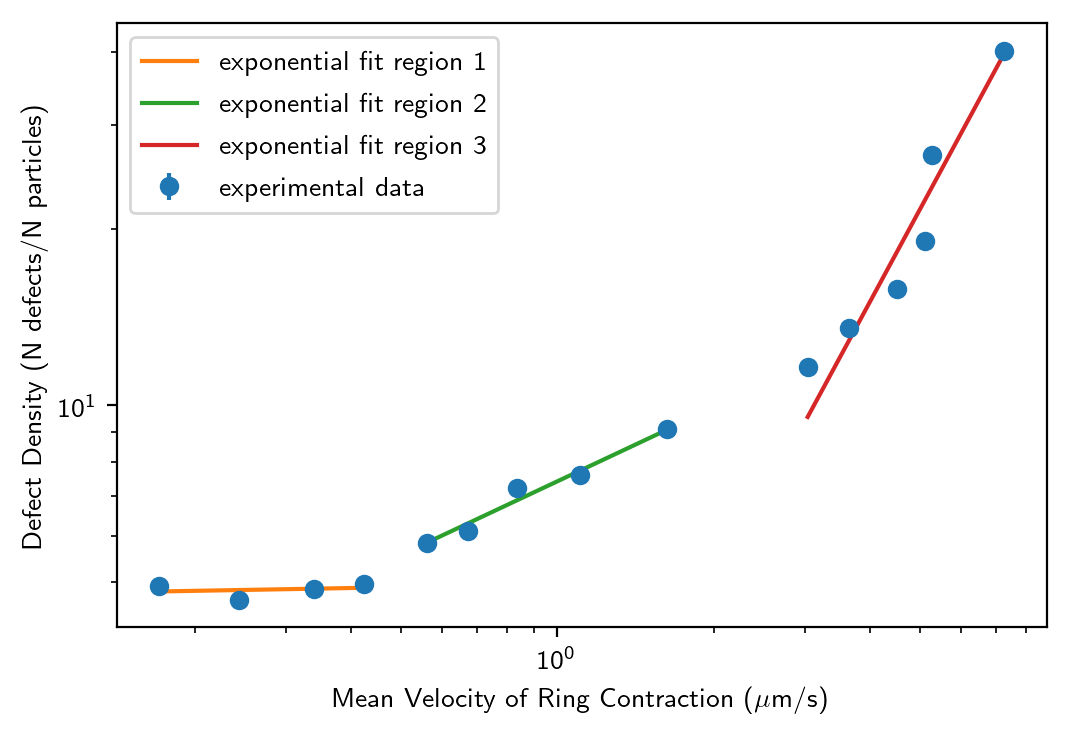

In [22]:
#plt.loglog(x,params[1]*x+params[0])
plt.errorbar(mean_vel.values, mean_walls.values, walls_err.values, fmt='o',label="experimental data")
plt.loglog(mean_vel[0:5],exponential(mean_vel[0:5],exp[0], exp[1]), label="exponential fit region 1")
plt.loglog(mean_vel[6:10],exponential(mean_vel[6:10],exp2[0], exp2[1]), label="exponential fit region 2")
plt.loglog(mean_vel[11:17],exponential(mean_vel[11:17],exp3[0], exp3[1]), label="exponential fit region 3")
plt.xlabel(r"Mean Velocity of Ring Contraction ($\mu$m/s)")
plt.ylabel("Defect Density (N defects/N particles)")
plt.legend()

In [21]:
print("Exponent region 1 = ", exp[0], "; Exponent region 2 = ", exp2[0], "; Exponent region 3 = ", exp3[0])

Exponent region 1 =  0.01592718001851579 ; Exponent region 2 =  0.4156733454004347 ; Exponent region 3 =  1.634598992293999


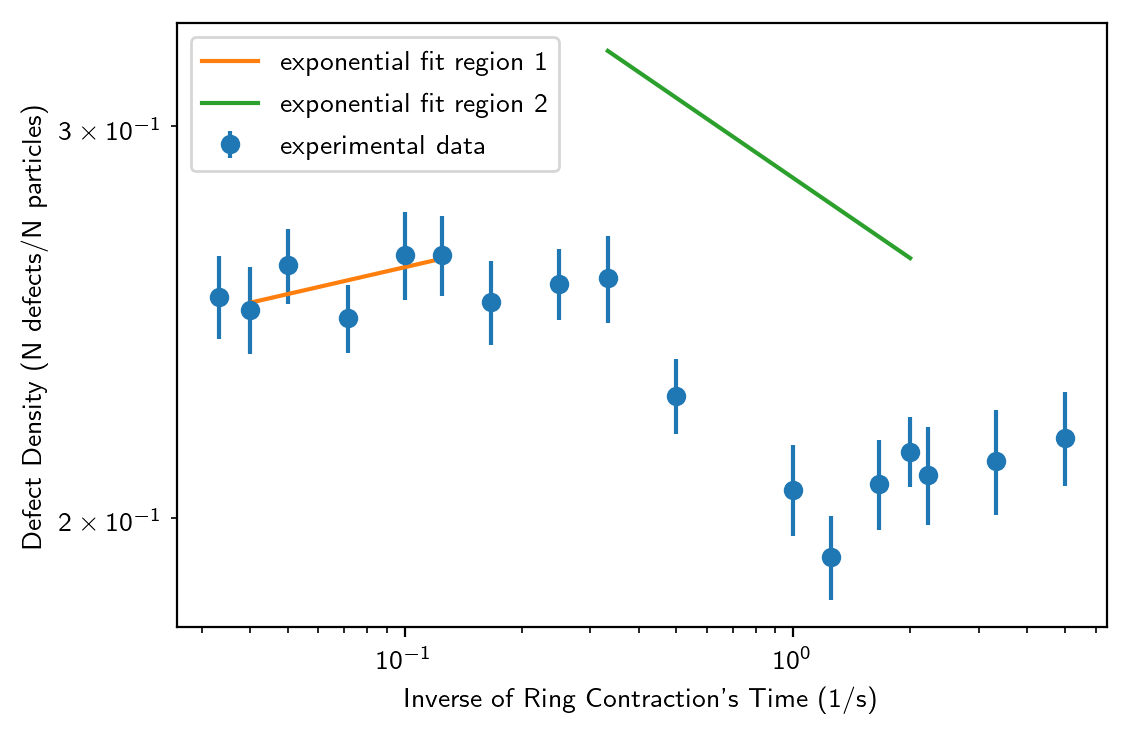

In [38]:
exp_inv, lin_cov = spo.curve_fit(exponential, mean_tinv[2:6], mean_walls[2:6])
exp_inv2, lin_cov2 = spo.curve_fit(exponential, mean_tinv[9:14], mean_walls[9:14])

plt.errorbar(mean_tinv.values, mean_walls.values, walls_err.values, fmt='o',label="experimental data")
plt.loglog(mean_tinv[2:6],exponential(mean_tinv[2:6],exp_inv[0], exp_inv[1]), label="exponential fit region 1")
plt.loglog(mean_tinv[9:14],exponential(mean_tinv[9:14],exp_inv2[0], exp_inv[1]), label="exponential fit region 2")
plt.xlabel(r"Inverse of Ring Contraction's Time (1/s)")
plt.ylabel("Defect Density (N defects/N particles)")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [39]:
print("Exponent fit region 1 = ", exp_inv[0], "; Exponent fit region 2 = ", exp_inv2[0] )

Exponent fit region 1 =  0.04015962549858319 ; Exponent fit region 2 =  -0.11983251738398408


# Test Cells

In [34]:
file = "KZ_data_20190912"
kzd = pd.read_csv(file, sep = "\t", index_col = [0,1])
kzd["defect_density"] = kzd.dom/50
kzd["vel"] = (-kzd.r+34.675)/kzd.time #34.675 is the initial radius
kzd["inv_time"] = 1/kzd.time
kzd.head()

dom  dom_length          r  time  defect_density       vel  \
test test_num                                                               
1.0  0.0       6.0    8.333333  31.204325  30.0            0.12  0.115689   
     1.0       4.0   12.500000  31.215399  30.0            0.08  0.115320   
     2.0       4.0   12.500000  31.202786  30.0            0.08  0.115740   
     3.0       4.0   12.500000  31.223551  30.0            0.08  0.115048   
     4.0       4.0   12.500000  31.211420  30.0            0.08  0.115453   

               inv_time  
test test_num            
1.0  0.0       0.033333  
     1.0       0.033333  
     2.0       0.033333  
     3.0       0.033333  
     4.0       0.033333

In [28]:
file = "KZ_data_20191003_2"
kzd_2 = pd.read_csv(file, sep = "\t", index_col = [0,1])
kzd_2["defect_density"] = kzd_2.n_walls/50
kzd_2["vel"] = (-kzd_2.r+34.675)/kzd_2.time #34.675 is the initial radius
kzd_2["inv_time"] = 1/kzd_2.time
kzd_2.head()

dom_length  n_walls          r  time  defect_density       vel  \
test test_num                                                                   
1.0  0.0             12.5      4.0  31.234733  30.0            0.08  0.114676   
     1.0             12.5      4.0  31.221817  30.0            0.08  0.115106   
     2.0             12.5      4.0  31.234752  30.0            0.08  0.114675   
     3.0             12.5      4.0  31.210882  30.0            0.08  0.115471   
     4.0             25.0      2.0  31.226575  30.0            0.04  0.114948   

               inv_time  
test test_num            
1.0  0.0       0.033333  
     1.0       0.033333  
     2.0       0.033333  
     3.0       0.033333  
     4.0       0.033333

In [29]:
#File 1
mean_vel = kzd.groupby("test").vel.mean()
mean_tinv = kzd.groupby("test").inv_time.mean()
mean_walls = kzd.groupby("test").defect_density.mean()
walls_std = kzd.groupby("test").defect_density.std()
walls_err = walls_std/np.sqrt(kzd.groupby("test").defect_density.count())

#File 2
mean_vel_2 = kzd_2.groupby("test").vel.mean()
mean_tinv_2 = kzd_2.groupby("test").inv_time.mean()
mean_walls_2 = kzd_2.groupby("test").defect_density.mean()
walls_std_2 = kzd_2.groupby("test").defect_density.std()
walls_err_2 = walls_std_2/np.sqrt(kzd_2.groupby("test").defect_density.count())

In [30]:
def exponential(x,A,B):
    return B*np.power(x,A)

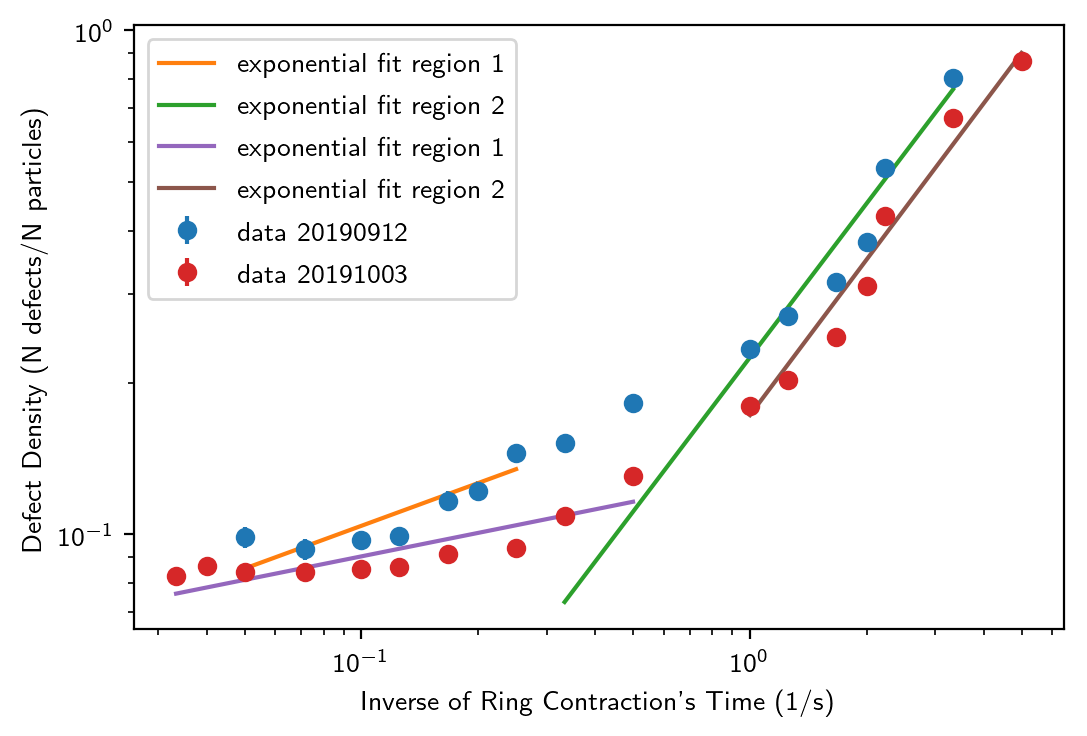

In [31]:
#File 1
array = np.concatenate((mean_tinv[2:6].values, np.array(mean_tinv[8])),axis=None)
array_walls = np.concatenate((mean_walls[2:6].values, np.array(mean_walls[8])),axis=None)
exp, lin_cov = spo.curve_fit(exponential, array, array_walls)
exp2, lin_cov2 = spo.curve_fit(exponential, mean_tinv[9:17], mean_walls[9:17])

plt.errorbar(mean_tinv.values, mean_walls.values, walls_err.values, fmt='o',label="data 20190912")
plt.loglog(array,exponential(array,exp[0], exp[1]), label="exponential fit region 1")
plt.loglog(mean_tinv[9:17],exponential(mean_tinv[9:17],exp2[0], exp2[1]), label="exponential fit region 2")


#File 2
exp_1_2, lin_cov = spo.curve_fit(exponential, mean_tinv_2[0:10], mean_walls_2[0:10])
exp_2_2, lin_cov2 = spo.curve_fit(exponential, mean_tinv_2[11:17], mean_walls_2[11:17])

plt.errorbar(mean_tinv_2.values, mean_walls_2.values, walls_err_2.values, fmt='o',label="data 20191003")
plt.loglog(mean_tinv_2[0:10],exponential(mean_tinv_2[0:10],exp_1_2[0], exp_1_2[1]), label="exponential fit region 1")
plt.loglog(mean_tinv_2[11:17],exponential(mean_tinv_2[11:17],exp_2_2[0], exp_2_2[1]), label="exponential fit region 2")

plt.xlabel(r"Inverse of Ring Contraction's Time (1/s)")
plt.ylabel("Defect Density (N defects/N particles)")
plt.xscale("log")
plt.yscale("log")
plt.legend();

In [40]:
print("Data 20190912: \t Exponent fit region 1 = ", exp[0], "; Exponent fit region 2 = ", exp2[0],
     "\nData 20191003: \t Exponent fit region 1 = ", exp_1_2[0], "; Exponent fit region 2 = ", exp_2_2[0],)

Data 20190912: 	 Exponent fit region 1 =  0.2316306961163851 ; Exponent fit region 2 =  1.0689602456382883 
Data 20191003: 	 Exponent fit region 1 =  0.15503368133003614 ; Exponent fit region 2 =  1.0283930719780994
